In [1]:
import pandas as pd
import numpy as np
from numpy import load
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import norm
from PIL import Image, ImageOps
from numpy import asarray
import os

In [2]:
### the model itsself should be the same as trained model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.pool = nn.MaxPool2d(2)
        self.relu = nn.functional.relu

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        ## the input features should be the flatten version of the outchannel from the last conv2d layer
        self.linear1 = nn.Linear(9856, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 256)
        self.linear4 = nn.Linear(256, 64)
        self.linear5 = nn.Linear(64, 32)
        self.linear6 = nn.Linear(32, 6)

    def forward(self, img):
        img_out = self.pool(self.relu(self.conv1(img)))
        img_out = self.pool(self.relu(self.conv2(img_out)))
        img_out = self.pool(self.relu(self.conv3(img_out)))
        img_out = self.pool(self.relu(self.conv4(img_out)))
        img_out = self.pool(self.relu(self.conv5(img_out)))

        img_out = nn.Flatten()(img_out)
#         print('image_out size:')
#         print(img_out.size())

        output = self.relu(self.linear1(img_out))
        output = self.relu(self.linear2(output))
        output = self.relu(self.linear3(output))
        output = self.relu(self.linear4(output))
        output = self.relu(self.linear5(output))
        output = self.linear6(output)

        return output
model = Net()
print(model)


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=9856, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=6, bias=True)
)


In [4]:
### load the trained model
PATH = '/home/bowen/Documents/Flexible-Tool/models/model_6000'
model.load_state_dict(torch.load(PATH))
model = model.eval()



In [5]:
### function for testing the model
def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for img, y in dataloader:
            pred = model(img)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [11]:
### generating the test dataset

a_array = load('a_array0.npy')
xy_array = np.zeros((N,288,432))
xz_array = np.zeros((N,288,432))

for i in range(N):
    ## on bowen's local
#     img1 = Image.open('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/png_data/'+str(i)+'_xy.png')
#     img2 = Image.open('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/png_data/'+str(i)+'_xz.png')
    
    ## on beast's local
    img1 = Image.open('/home/bowen/Documents/Flexible-Tool/png_data/'+str(i)+'_xy.png')
    img2 = Image.open('/home/bowen/Documents/Flexible-Tool/png_data/'+str(i)+'_xz.png')
    img1 = ImageOps.grayscale(img1)
    img2 = ImageOps.grayscale(img2)
    
    xy_array[i,:,:] = asarray(img1)
    xz_array[i,:,:] = asarray(img2)

In [12]:
print(xy_array.shape)
print(xz_array.shape)

(6000, 288, 432)
(6000, 288, 432)


In [13]:
## put two image arraies into one single array with two channels and then reshape it because of the format of pytorch
image_array = np.stack([xy_array,xz_array], axis = -1).squeeze()
image_array = np.transpose(image_array,[0,3,1,2]) ## change the axis
print(image_array.shape)

(6000, 2, 288, 432)


In [14]:
## split image data and a_array into test and train set and put them into tensor and dataloader
image_test_x = (image_array[int(0.8*N):N,:,:,:]).astype(np.float32) 

test_y = (a_array[int(0.8*N):N,:]).astype(np.float32)

y_test_tensor = torch.from_numpy(test_y)

imagex_test_tensor = torch.from_numpy(image_test_x)
test_data = [(imagex_test_tensor[i],y_test_tensor[i]) for i in range(imagex_test_tensor.shape[0])]

In [15]:
test_dataset = torch.utils.data.TensorDataset(imagex_test_tensor, y_test_tensor)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 500, shuffle=True)

for batch, (img,y) in enumerate(test_loader):
    print("batch", batch)
    print("Shape of img: ", img.shape, img.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

batch 0
Shape of img:  torch.Size([500, 2, 288, 432]) torch.float32
Shape of y:  torch.Size([500, 6]) torch.float32


In [18]:
N = 6000
n = np.random.randint(0,int(0.2*N))
img,y = test_dataset[n]
img = torch.unsqueeze(img, 0) 
# q = torch.unsqueeze(q, 0) 
pred = model(img)
print(pred[0])
print(y_test_tensor[n])

tensor([0.4389, 0.5689, 0.3427, 0.4630, 0.5576, 0.4551],
       grad_fn=<SelectBackward>)
tensor([0.1647, 0.4800, 0.4788, 0.2930, 0.8339, 0.6549])


In [23]:
### Plot results

plt.figure(figsize=(16,10))
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
# axes.set_ylim([0.06,0.09])
axes.set_ylim([0,1.0])
plt.show()

NameError: name 'test_loss_list' is not defined

<Figure size 1152x720 with 0 Axes>

In [26]:
q_array = load('q_array0.npy')
q_actual = (q_array[int(0.8*N):N,:]).astype(np.float32)

In [24]:
### Compare predicted q to actual q
from gekko import GEKKO



### get a, q from above (convert a and q from tensor to cpu and then to numpy array)
a = pred[0].cpu().detach().numpy() 
# q_actual = x_test_tensor[n].cpu().detach().numpy()

##################################################
### Equations for mu's ###########################
##################################################

m = GEKKO()            # create GEKKO model

# define parameters
c1 = 1.0
c2 = 1.0
c3 = 1.0
t_steps = 100
m.time = np.linspace(0,1,t_steps) # t range [0,1]
t = m.Param(value=m.time)

# define variables
# initial conditions mu(0) = a
mu1 = m.Var(value=a[0])
mu2 = m.Var(value=a[1])
mu3 = m.Var(value=a[2])
mu4 = m.Var(value=a[3])
mu5 = m.Var(value=a[4])
mu6 = m.Var(value=a[5])

# define equations
m.Equation(mu1.dt() == (c3**-1)*mu3*mu2 - (c2**-1)*mu2*mu3)
m.Equation(mu2.dt() == mu6 + (c1**-1)*mu1*mu3 - (c3**-1)*mu3*mu1)
m.Equation(mu3.dt() == -mu5 + (c2**-1)*mu2*mu1 - (c1**-1)*mu1*mu2)
m.Equation(mu4.dt() == (c3**-1)*mu3*mu5 - (c2**-1)*mu2*mu6)
m.Equation(mu5.dt() == (c1**-1)*mu1*mu6 - (c3**-1)*mu3*mu4)
m.Equation(mu6.dt() == (c2**-1)*mu2*mu4 - (c1**-1)*mu1*mu5)


##################################################
### Equations for q's ############################
##################################################

# define variables
# initial condition q(0) = I
q11 = m.Var(value = 1.0)
q12 = m.Var(value = 0.0)
q13 = m.Var(value = 0.0)
q14 = m.Var(value = 0.0)
q21 = m.Var(value = 0.0)
q22 = m.Var(value = 1.0)
q23 = m.Var(value = 0.0)
q24 = m.Var(value = 0.0)
q31 = m.Var(value = 0.0)
q32 = m.Var(value = 0.0)
q33 = m.Var(value = 1.0)
q34 = m.Var(value = 0.0)
q41 = m.Var(value = 0.0)
q42 = m.Var(value = 0.0)
q43 = m.Var(value = 0.0)
q44 = m.Var(value = 1.0)

# define equations
m.Equation(q11.dt() == q12*(mu3/c3) - q13*(mu2/c2))
m.Equation(q21.dt() == q22*(mu3/c3) - q23*(mu2/c2))
m.Equation(q31.dt() == q32*(mu3/c3) - q33*(mu2/c2))
m.Equation(q41.dt() == q42*(mu3/c3) - q43*(mu2/c2))
m.Equation(q12.dt() == -q12*(mu3/c3) + q14*(mu1/c1))
m.Equation(q22.dt() == -q22*(mu3/c3) + q24*(mu1/c1))
m.Equation(q32.dt() == -q32*(mu3/c3) + q34*(mu1/c1))
m.Equation(q42.dt() == -q42*(mu3/c3) + q44*(mu1/c1))
m.Equation(q13.dt() == q11*(mu2/c2) - q12*(mu1/c1))
m.Equation(q23.dt() == q21*(mu2/c2) - q22*(mu1/c1))
m.Equation(q33.dt() == q31*(mu2/c2) - q32*(mu1/c1))
m.Equation(q43.dt() == q41*(mu2/c2) - q42*(mu1/c1))
m.Equation(q14.dt() == q11)
m.Equation(q24.dt() == q21)
m.Equation(q34.dt() == q31)
m.Equation(q44.dt() == q41)



##################################################
### Solve Equations ##############################
##################################################
m.options.IMODE=4
m.solve(disp=False)

q = [q11, q12, q13, q14, q21, q22, q23, q24, q31, q32, q33, q34, q41, q42, q43, q44]
#     print("a=",a)
#     print("q=",q)

# Print
print('a =', a[0], a[1], a[2], a[3], a[4], a[5])
print('b =', q14[-1], q24[-1], q34[-1])
print(" ")


a = 0.43887472 0.56885844 0.34269035 0.4630198 0.5576463 0.45508218
b = 0.90843330694 0.119168828 -0.34784834473
 


In [28]:

### plot the initial trajectory in 3D
from mpl_toolkits import mplot3d

### Interpret q's
x = [q14[i] for i in range(t_steps)]
y = [q24[i] for i in range(t_steps)]
z = [q34[i] for i in range(t_steps)]

x_actual = [q_actual[0][3][i] for i in range(t_steps)]
y_actual = [q_actual[0][7][i] for i in range(t_steps)]
z_actual = [q_actual[0][11][i] for i in range(t_steps)]

MSE = np.square(np.subtract(q_actual[0][:][:],q)).mean()
print("MSE = ", MSE)

MSE =  0.006167048819302552


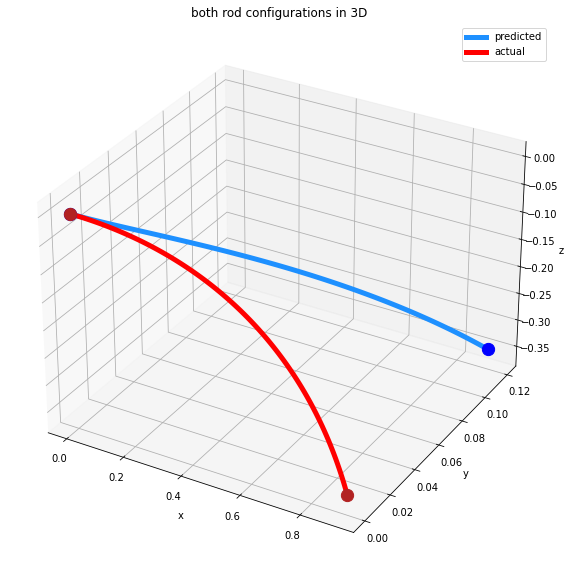

In [30]:
fig1 = plt.figure(figsize = (12,10))
ax1 = plt.axes(projection ='3d')
ax1.scatter(x[0], y[0], z[0], marker='o', s=150, color='blue')
ax1.scatter(x[-1], y[-1], z[-1], marker='o', s=150, color='blue')
ax1.scatter(x_actual[0], y_actual[0], z_actual[0], marker='o', s=150, color='firebrick')
ax1.scatter(x_actual[-1], y_actual[-1], z_actual[-1], marker='o', s=150, color='firebrick')
ax1.set_title('both rod configurations in 3D')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot3D(x, y, z, color='dodgerblue', linewidth=5, label='predicted')
ax1.plot3D(x_actual, y_actual, z_actual, color='red', linewidth=5, label='actual')
plt.legend()